# 以下是神经网络方法。

In [1]:
import os
from datetime import datetime

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adagrad, Adam
from torchvision import datasets, models, transforms
from torchvision.models import (ResNet18_Weights, ResNet50_Weights,
                                VGG11_Weights, resnet18, resnet50, vgg11)
from tqdm import tqdm

from dataset import MyDataset
from my_mlp import MyMLP
from utils import label_int2str, label_str2int, save_config


device = "cuda"
assert torch.cuda.is_available(), "你TM连CUDA都没你跑个JB"

CUDA availability: True


## 运行设置：

In [2]:
# Run name
run_name = datetime.now().strftime("%Y-%m-%d %H.%M.%S")

# Network architecture
# mlp, resnet18, resnet50, vgg11
model_name = "resnet18"
model_is_pretrained = False
num_classes = 6

# Optimizer
# SGD, Adagrad, Adam
optimizer_name = "Adam"
lr = 3e-3

# Data augmentation
# "none", "flip", "crop", "norm", "all"
augmentation = "none"

# Regularization
# "none", "weight_decay", "dropout", "both"
regularization = "both"

## 模型网络架构：

(Reference from pytorch.org)

| Weight |Acc@1 |Acc@5 |Params |GFLOPS|
| ---- | ---- | ---- | ---- | ---- |
| ResNet18_Weights.IMAGENET1K_V1 | 69.758 | 89.078 | 11.7M | 1.81 |
| ResNet50_Weights.IMAGENET1K_V2 | 80.858 | 95.434 | 25.6M | 4.09 |
| VGG11_Weights.IMAGENET1K_V1 | 69.02 | 88.628 | 132.9M | 7.61 |

In [3]:
if model_name=="mlp":
    model = MyMLP(150*150*3, num_classes)
    input_size = (150, 150)
elif model_name=="resnet18":
    if model_is_pretrained:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18(weights=None)
    input_size = (224, 224)
    model.fc = torch.nn.Linear(512, num_classes)
elif model_name=="resnet50":
    if model_is_pretrained:
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        model = resnet50(weights=None)
    input_size = (224, 224)
    model.fc = torch.nn.Linear(512, num_classes)
elif model_name=="vgg11":
    if model_is_pretrained:
        model = vgg11(weights=VGG11_Weights.DEFAULT)
    else:
        model = vgg11(weights=None)
    input_size = (224, 224)
    model.classifier[6] = torch.nn.Linear(4096,num_classes)


# Add dropout to the model
def append_dropout(model, rate=0.2):
        for name, module in model.named_children():
            if len(list(module.children())) > 0:
                append_dropout(module)
            if isinstance(module, torch.nn.ReLU):
                new = torch.nn.Sequential(module, torch.nn.Dropout2d(p=rate))
                setattr(model, name, new)
                
if regularization in ["dropout", "both"]:
    append_dropout(model)

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.2, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.2, inplace=False)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

## 优化器：

In [4]:
if optimizer_name=="SGD":
    if regularization in ["none", "dropout"]:
        optimizer = SGD(model.parameters(), lr=lr)
    elif regularization in ["weight_decay", "both"]:
        optimizer = SGD(model.parameters(), weight_decay=0.001, lr=lr)
elif optimizer_name=="Adagrad":
    if regularization in ["none", "dropout"]:
        optimizer = Adagrad(model.parameters(), lr=lr)
    elif regularization in ["weight_decay", "both"]:
        optimizer = Adagrad(model.parameters(), weight_decay=0.001, lr=lr)
elif optimizer_name=="Adam":
    if regularization in ["none", "dropout"]:
        optimizer = Adam(model.parameters(), lr=lr)
    elif regularization in ["weight_decay", "both"]:
        optimizer = Adam(model.parameters(), weight_decay=0.001, lr=lr)


## 数据增强与预处理：

In [5]:
if augmentation=="none":
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])
elif augmentation=="flip":
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor()
    ])
elif augmentation=="crop":
    transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size), 
        transforms.ToTensor()
    ])
elif augmentation=="norm":    
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
    ])
elif augmentation=="all":
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomResizedCrop(input_size), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
    ])

dataset = datasets.ImageFolder("./dataset/seg_train/", transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

## 训练过程：

In [6]:
def train_one_epoch(model: torch.nn.Module, dataloader: DataLoader, transform: transforms.Compose, 
                    optimizer: torch.optim.Optimizer, current_epoch: int):
    correct_predictions = 0
    epoch_instance_count = 0
    epoch_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training epoch %d"%current_epoch):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        correct_predictions += torch.sum(predictions==labels.data).item()
        epoch_instance_count += inputs.size(0)
    epoch_accuracy = correct_predictions/epoch_instance_count
    epoch_loss /= epoch_instance_count
    if current_epoch%1==0:
        print("Epoch %d (%d instances), loss = %f, accuracy = %f"%(current_epoch, epoch_instance_count, epoch_loss, epoch_accuracy))
    if current_epoch%10==0:
        os.makedirs("./outputs/runs/%s"%run_name, exist_ok=True)
        torch.save(model, "./outputs/runs/%s/model_epoch_%d"%(run_name, current_epoch))
    return epoch_loss, epoch_accuracy

epoch_losses = []
epoch_accuracies = []
model.train()
for epoch in range(1, 61):
    epoch_loss, epoch_accuracy = train_one_epoch(model, dataloader, transform, optimizer, epoch)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)


Training epoch 1: 100%|██████████| 439/439 [00:34<00:00, 12.73it/s]


Epoch 1 (14034 instances), loss = 1.402228, accuracy = 0.434801


Training epoch 2: 100%|██████████| 439/439 [00:29<00:00, 14.68it/s]


Epoch 2 (14034 instances), loss = 1.161857, accuracy = 0.531994


Training epoch 3: 100%|██████████| 439/439 [00:29<00:00, 14.70it/s]


Epoch 3 (14034 instances), loss = 1.113657, accuracy = 0.553727


Training epoch 4: 100%|██████████| 439/439 [00:30<00:00, 14.54it/s]


Epoch 4 (14034 instances), loss = 1.076994, accuracy = 0.566054


Training epoch 5: 100%|██████████| 439/439 [00:30<00:00, 14.56it/s]


Epoch 5 (14034 instances), loss = 1.059272, accuracy = 0.575531


Training epoch 6: 100%|██████████| 439/439 [00:30<00:00, 14.47it/s]


Epoch 6 (14034 instances), loss = 1.038069, accuracy = 0.586362


Training epoch 7: 100%|██████████| 439/439 [00:30<00:00, 14.61it/s]


Epoch 7 (14034 instances), loss = 1.013524, accuracy = 0.594485


Training epoch 8: 100%|██████████| 439/439 [00:29<00:00, 14.91it/s]


Epoch 8 (14034 instances), loss = 0.997182, accuracy = 0.597763


Training epoch 9: 100%|██████████| 439/439 [00:29<00:00, 14.67it/s]


Epoch 9 (14034 instances), loss = 0.982810, accuracy = 0.611159


Training epoch 10: 100%|██████████| 439/439 [00:30<00:00, 14.62it/s]


Epoch 10 (14034 instances), loss = 0.973409, accuracy = 0.611800


Training epoch 11: 100%|██████████| 439/439 [00:30<00:00, 14.58it/s]


Epoch 11 (14034 instances), loss = 0.958381, accuracy = 0.618498


Training epoch 12: 100%|██████████| 439/439 [00:30<00:00, 14.53it/s]


Epoch 12 (14034 instances), loss = 0.940759, accuracy = 0.631466


Training epoch 13: 100%|██████████| 439/439 [00:30<00:00, 14.61it/s]


Epoch 13 (14034 instances), loss = 0.929086, accuracy = 0.636811


Training epoch 14: 100%|██████████| 439/439 [00:30<00:00, 14.46it/s]


Epoch 14 (14034 instances), loss = 0.915285, accuracy = 0.642654


Training epoch 15: 100%|██████████| 439/439 [00:30<00:00, 14.51it/s]


Epoch 15 (14034 instances), loss = 0.915837, accuracy = 0.647570


Training epoch 16: 100%|██████████| 439/439 [00:28<00:00, 15.32it/s]


Epoch 16 (14034 instances), loss = 0.910581, accuracy = 0.648140


Training epoch 17: 100%|██████████| 439/439 [00:27<00:00, 15.83it/s]


Epoch 17 (14034 instances), loss = 0.910040, accuracy = 0.650064


Training epoch 18: 100%|██████████| 439/439 [00:28<00:00, 15.51it/s]


Epoch 18 (14034 instances), loss = 0.900429, accuracy = 0.653342


Training epoch 19: 100%|██████████| 439/439 [00:27<00:00, 15.70it/s]


Epoch 19 (14034 instances), loss = 0.901645, accuracy = 0.652344


Training epoch 20: 100%|██████████| 439/439 [00:27<00:00, 16.11it/s]


Epoch 20 (14034 instances), loss = 0.892862, accuracy = 0.659185


Training epoch 21:  73%|███████▎  | 322/439 [00:21<00:07, 14.92it/s]


KeyboardInterrupt: 

In [ ]:
save_config(run_name, model_name, model_is_pretrained, num_classes, optimizer_name, lr, augmentation, regularization)

## 测试网络：

In [7]:
# run_name = "2023-05-14 21.22.16"
model = torch.load("./outputs/runs/%s/model_epoch_20"%run_name)
def test(model: torch.nn.Module, dataloader: DataLoader):
    correct_predictions = 0
    epoch_instance_count = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += torch.sum(predictions==labels.data)
            epoch_instance_count += inputs.size(0)
    epoch_accuracy = correct_predictions/epoch_instance_count
    print("Testing (%d instances), accuracy = %f"%(epoch_instance_count, epoch_accuracy))

testset = datasets.ImageFolder("./dataset/seg_test/", transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])) # Do not transform input images in testing. 
testloader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)
test(model, testloader)


Testing: 100%|██████████| 94/94 [00:03<00:00, 26.80it/s]

Testing (3000 instances), accuracy = 0.703000


## 画图

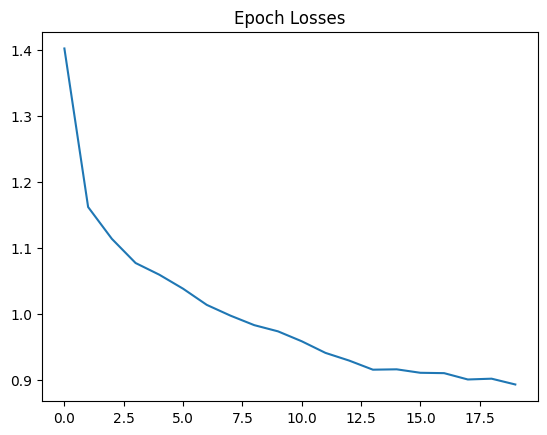

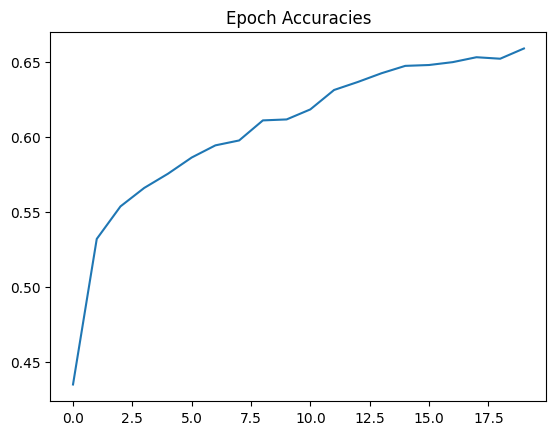

In [8]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.title("Epoch Losses")
plt.savefig("./outputs/runs/%s/loss.png"%run_name)
plt.show()
plt.plot(epoch_accuracies)
plt.title("Epoch Accuracies")
plt.savefig("./outputs/runs/%s/acc.png"%run_name)
plt.show()